In [3]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

In [54]:
def snake_case_all_and_remove_columns(df, keep_columns):
    columns_rename = {}
    for i in list(df.columns):
        columns_rename[i] = i.lower().replace("'", '').split(" (")[0].replace(' ', '_').replace('no_', 'nb_')
    return df[keep_columns].rename(columns=columns_rename)


def fillnas(df, columns_na_fills):
    for i in columns_na_fills.keys():
        df.loc[df[i].isnull(),i]=columns_na_fills[i]
    return df


def change_columns_type(df, cols_dict):
    for c in cols_dict.keys():
        if cols_dict[c] == 'int':
            df[c] = df[c].astype(int)
        elif cols_dict[c] == 'str':
            df[c] = df[c].astype(str)
        elif cols_dict[c] == 'float':
            df[c] = df[c].astype(float)
    return df

keep_cols = ['Dis No', 'Year', 'Seq', 'Disaster Group', 'Disaster Subgroup', 'Disaster Type', 'Disaster Subtype', 
             'Disaster Subsubtype', 'Event Name', 'Country', 'ISO', 'Continent', 'Location', 'Origin', 'Associated Dis',
             'Associated Dis2', 'Aid Contribution', 'Dis Mag Value', 'Dis Mag Scale', 'Latitude', 'Longitude', 'Local Time',
             'River Basin',  'Start Year', 'Start Month', 'Start Day', 'End Year', 'End Month','End Day', 'Total Deaths', 
             'No Injured', 'No Affected', 'No Homeless', 'Geo Locations','Total Affected', "Reconstruction Costs ('000 US$)",
             "Insured Damages ('000 US$)", "Total Damages ('000 US$)"]

columns_na_fills = {'start_month' : 1, 
                    'start_day' : 1, 
                    'end_month' : 1, 
                    'end_day' : 1}


change_cols = {'start_year' : 'str',
               'start_month' : 'str', 
               'start_day' : 'str', 
               'end_year' : 'str', 
               'end_month' : 'str', 
               'end_day' : 'str',
              }

df = pd.read_csv('data\\natural_disasters_raw.csv', sep=';')

df_clean = (df.drop_duplicates()
              .pipe(snake_case_all_and_remove_columns, keep_cols)
              .pipe(fillnas, columns_na_fills)
              #.pipe(change_columns_type, change_cols)   
              .assign(start_date = lambda df: pd.to_datetime(dict(year=df.start_year, month=df.start_month, day=df.start_day)
                                                             , format='%Y-%m-%d', errors='coerce'))
              .assign(end_date = lambda df: pd.to_datetime(dict(year=df.end_year, month=df.end_month, day=df.end_day)
                                                              , format='%Y-%m-%d', errors='coerce'))    
                     )

df_clean['start_year'] = df_clean['start_year'].astype(int).astype(str)
df_clean['start_month'] = df_clean['start_month'].astype(float).astype(int).astype(str)
df_clean['start_month'] = df_clean['start_month'].apply(lambda x: x if len(x) > 1 else ('0'+x))
df_clean['start_ym'] = df_clean['start_year'] + '-' + df_clean['start_month']

In [70]:
dis_grouped = df_clean.groupby('start_ym').count()[['dis_no']].reset_index()

In [10]:
df_trend = pd.read_csv('data\\climate_change_topic_google_trends.csv', sep=',')

In [68]:
df_trend_clean = df_trend.pipe(snake_case_all_and_remove_columns, df_trend.columns)

In [69]:
df_trend_clean.head()

,month,climate_change_worldwide
0,2004-01,27
1,2004-02,37
2,2004-03,39
3,2004-04,33
4,2004-05,36


In [73]:
df_merge = df_trend_clean.merge(dis_grouped, how='left', left_on='month', right_on = 'start_ym').fillna(0)

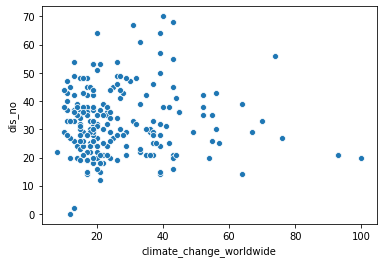

In [74]:
sns.scatterplot(data=df_merge, x="climate_change_worldwide", y="dis_no")

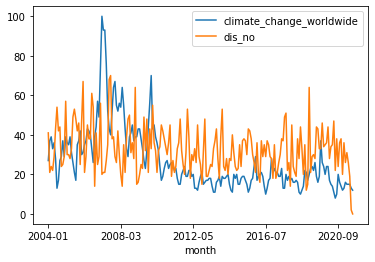

In [77]:
df_merge.set_index('month')[['climate_change_worldwide', 'dis_no']].plot()

In [87]:
df_clean.head()

,dis_no,year,seq,disaster_group,disaster_subgroup,disaster_type,disaster_subtype,disaster_subsubtype,event_name,country,...,nb_affected,nb_homeless,geo_locations,total_affected,reconstruction_costs,insured_damages,total_damages,start_date,end_date,start_ym
0,1990-9579-CMR,1990,9579,Natural,Climatological,Drought,Drought,NaN,NaN,Cameroon,...,186900.0,NaN,NaN,186900.0,NaN,NaN,NaN,1990-01-01,1991-01-01,1990-01
1,1990-0230-ECU,1990,230,Natural,Geophysical,Earthquake,Ground movement,NaN,NaN,Ecuador,...,6500.0,NaN,NaN,6510.0,NaN,NaN,NaN,1990-08-11,1990-08-11,1990-08
2,1990-0272-AUS,1990,272,Natural,Meteorological,Storm,Convective storm,Hail,NaN,Australia,...,NaN,NaN,NaN,NaN,NaN,389100.0,389100.0,1990-03-18,1990-03-18,1990-03
3,1990-0361-AUT,1990,361,Natural,Meteorological,Storm,Convective storm,Severe storm,NaN,Austria,...,NaN,NaN,NaN,NaN,NaN,28200.0,NaN,1990-05-22,1990-05-22,1990-05
4,1990-9059-BOL,1990,9059,Natural,Climatological,Drought,Drought,NaN,NaN,Bolivia (Plurinational State of),...,283160.0,NaN,NaN,283160.0,NaN,NaN,NaN,1990-01-01,1990-01-01,1990-01


In [102]:
df_clean.query("start_date >= '2020-01-01'").query("disaster_type == 'Flood'").groupby('country').count()[['dis_no']].sort_values('dis_no', ascending=False).head(10)

,dis_no
country,
Indonesia,33
Brazil,11
Peru,9
Malaysia,7
Iran (Islamic Republic of),7
Yemen,6
Rwanda,6
Congo (the Democratic Republic of the),6
Colombia,6


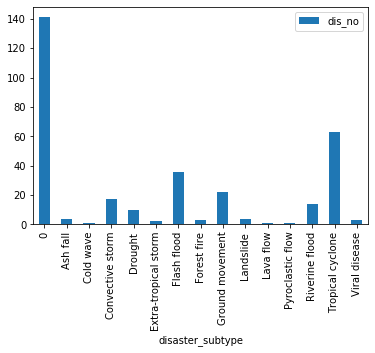

In [96]:
df_clean.query("start_date >= '2020-01-01'").fillna(0).query("total_affected > 1000").groupby('disaster_subtype').count()[['dis_no']].plot.bar()